In [31]:
import os

files = os.listdir(r'machines/')
len(files)

4023

In [2]:
import os

files = os.listdir(r'machines/')
missing = [n+1 for n in range(4034) if f'm_{n+1}.csv' not in files]
missing

[192, 374, 1040, 1074, 1483, 1495, 1807, 2715, 3344, 3404, 3520]

In [3]:
import pandas as pd
missing = [192, 374, 1040, 1074, 1483, 1495, 1807, 2715, 3344, 3404, 3520]
machines = [f'm_{n+1}.csv' for n in range(4034) if n+1 not in missing]
records = [len(pd.read_csv(r'machines/' + machine)) for machine in machines]
machine_records = (
    pd.DataFrame({'machine':machines, 'records':records})
    .sort_values('records')
    .reset_index(drop=True)
)
             
print(machine_records)

         machine  records
0     m_3539.csv     3569
1     m_3306.csv     6948
2     m_2540.csv     9826
3      m_556.csv    18318
4      m_669.csv    22537
...          ...      ...
4018   m_103.csv    64675
4019  m_2773.csv    64698
4020  m_2967.csv    64787
4021   m_694.csv    65041
4022  m_3330.csv    65043

[4023 rows x 2 columns]


In [4]:
import matplotlib.pyplot as plt
machine = 'm_3330.csv'
df = pd.read_csv(r'machines/' + machine, 
                 names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                          'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
df

,machine_id,time_stamp,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
0,m_3330,10,28,91,NaN,NaN,45.21,38.10,3
1,m_3330,130,20,91,NaN,NaN,45.21,38.10,4
2,m_3330,160,19,92,NaN,NaN,45.22,38.10,4
3,m_3330,170,16,92,NaN,NaN,45.22,38.10,4
4,m_3330,280,20,92,NaN,NaN,45.22,38.10,4
...,...,...,...,...,...,...,...,...,...
65039,m_3330,690860,30,92,7.08,0.0,62.64,55.28,7
65040,m_3330,690870,34,92,3.65,0.0,62.64,55.28,7
65041,m_3330,690880,32,92,4.11,0.0,62.64,55.28,7
65042,m_3330,690910,30,91,5.19,0.0,62.64,55.28,4


In [5]:
import pandas as pd

def dataframe(file):
    df = pd.read_csv(r'machines/' + file, 
                     usecols=[1, 2, 3],
                     names=['time_stamp', 'cpu', 'mem'])
    df.time_stamp = pd.to_datetime(df.time_stamp, unit='s')
    df.set_index('time_stamp', inplace=True)
    df = df.resample('5min').interpolate()
    df = df.dropna()
    return df

print(dataframe('m_3330.csv'))

                      cpu   mem
time_stamp                     
1970-01-01 00:00:00  17.0  92.0
1970-01-01 00:05:00  20.0  92.0
1970-01-01 00:10:00  34.0  95.0
1970-01-01 00:15:00  27.0  93.0
1970-01-01 00:20:00  33.0  95.0
...                   ...   ...
1970-01-08 23:35:00  21.0  89.0
1970-01-08 23:40:00  25.0  90.0
1970-01-08 23:45:00  19.0  88.0
1970-01-08 23:50:00  19.0  88.0
1970-01-08 23:55:00  25.0  92.0

[2304 rows x 2 columns]


<AxesSubplot:xlabel='time_stamp'>

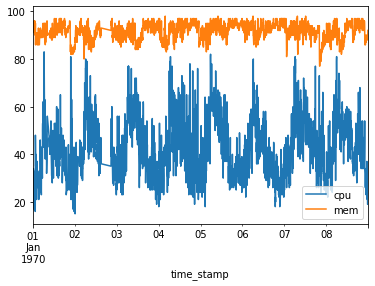

In [6]:
dataframe('m_3330.csv').plot()

Text(0.5, 0, 'tempo')

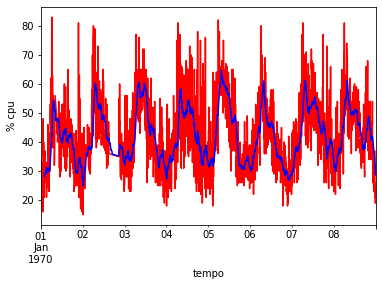

In [7]:
# Média Móvel
import matplotlib.pyplot as plt
df = dataframe('m_3330.csv')
df['cpu_sma'] = df.cpu.rolling(24).mean()
df.cpu.plot(color = ['red'])
df.cpu_sma.plot(color = ['blue'])
plt.ylabel('% cpu')
plt.xlabel('tempo')

Text(0.5, 0, 'tempo')

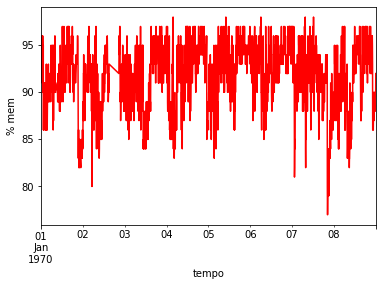

In [8]:
import matplotlib.pyplot as plt
df = dataframe('m_3330.csv')
df.mem.plot(color = ['red'])
plt.ylabel('% mem')
plt.xlabel('tempo')

In [46]:
from statsmodels.tsa.ar_model import AR

def emq(serie, order):
    train_size = int(len(serie) * 2/3)
    train_set = serie[:train_size]
    test_set = serie[train_size:]

    model = AR(train_set, freq='5T').fit(order)
    model.params

    previsao = model.params[0]
    for i, coef in enumerate(model.params[1:]):
        previsao += coef * test_set.shift(i + 1)
    return ((test_set - previsao) ** 2).mean()
emq(dataframe('m_3330.csv').cpu,1)

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATIO

70.95945561754723

In [33]:
import time
from statsmodels.tsa.ar_model import AR

def ar_model(serie, order):
    orders = range(1, order**2+1)
    best_error = 100000
    order_list = []
    error_list = []
    proc_time_list = []
    for order in orders:
        start_time = time.time()
        try:
            error = emq(serie, order)
            order_list.append(order)
            error_list.append(error)
            proc_time = time.time() - start_time
            proc_time_list.append(proc_time)
            
            if error < best_error:
                best_error = error
                best_order = order
                best_time = proc_time
            print('AR', f'({order})', error, proc_time)
        except:
            pass
    print({'model':'AR', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time})
    return {'model':'AR', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time, 
            'order_list':order_list, 'error_list':error_list, 'proc_time_list':proc_time_list}
ar_model(dataframe('m_3330.csv').cpu,1)

AR (1) 70.95945561754723 0.006343364715576172
{'model': 'AR', 'best_order': 1, 'best_error': 70.95945561754723, 'best_time': 0.006343364715576172}


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATIO

{'model': 'AR',
 'best_order': 1,
 'best_error': 70.95945561754723,
 'best_time': 0.006343364715576172,
 'order_list': [1],
 'error_list': [70.95945561754723],
 'proc_time_list': [0.006343364715576172]}

In [34]:
import time
from statsmodels.tsa.arima_model import ARMA
    
def arma_model(serie, order):
    
    orders = [(p+1, q+1) for p in range(order) for q in range(order)] #[(1,1), (2,1), (1,2), (3,1), (3,2), (3,3), (4,1), (4,2), (4,3), (4,4), (5,1), (5,2), (5,3), (5,4), (5,5)]
    best_error = 100000
    order_list = []
    error_list = []
    proc_time_list = []
    for order in orders:
        start_time = time.time()
        try:
            model = ARMA(serie, freq='5T', order=order).fit()
            error = (model.resid ** 2).mean()
            order_list.append(order)
            error_list.append(error)
            proc_time = time.time() - start_time
            proc_time_list.append(proc_time)
            
            if error < best_error:
                best_error = error
                best_order = order
                best_time = proc_time
            print('ARMA', order, error, proc_time)
        except:
            pass
    print({'model':'ARMA', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time})
    return {'model':'ARMA', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time, 
            'order_list':order_list, 'error_list':error_list, 'proc_time_list':proc_time_list}
arma_model(dataframe('m_3330.csv').cpu,1)

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 1) 69.39718780196777 0.7428007125854492
{'model': 'ARMA', 'best_order': (1, 1), 'best_error': 69.39718780196777, 'best_time': 0.7428007125854492}


{'model': 'ARMA',
 'best_order': (1, 1),
 'best_error': 69.39718780196777,
 'best_time': 0.7428007125854492,
 'order_list': [(1, 1)],
 'error_list': [69.39718780196777],
 'proc_time_list': [0.7428007125854492]}

In [35]:
import time
from statsmodels.tsa.arima_model import ARIMA
    
def arima_model(serie, order):

    orders = [(p+1, 1, q+1) for p in range(order) for q in range(order)] #[(1,1,1), (2,1,1), (1,1,2), (3,1,1), (3,1,2), (3,1,3), (4,1,1), (4,1,2), (4,1,3), (4,1,4), (5,1,1), (5,1,2), (5,1,3), (5,1,4), (5,1,5)]
    best_error = 100000
    order_list = []
    error_list = []
    proc_time_list = []
    for order in orders:
        start_time = time.time()
        try:
            model = ARIMA(serie, freq='5T', order=order).fit()
            error = (model.resid ** 2).mean()
            order_list.append(order)
            error_list.append(error)
            proc_time = time.time() - start_time
            proc_time_list.append(proc_time)
            
            if error < best_error:
                best_error = error
                best_order = order
                best_time = proc_time
            print('ARIMA', order, error, proc_time)
        except:
            pass
    print({'model':'ARIMA', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time})
    return {'model':'ARIMA', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time, 
            'order_list':order_list, 'error_list':error_list, 'proc_time_list':proc_time_list}
arima_model(dataframe('m_3330.csv').cpu,1)

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (1, 1, 1) 69.24608949733421 0.6640725135803223
{'model': 'ARIMA', 'best_order': (1, 1, 1), 'best_error': 69.24608949733421, 'best_time': 0.6640725135803223}


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'model': 'ARIMA',
 'best_order': (1, 1, 1),
 'best_error': 69.24608949733421,
 'best_time': 0.6640725135803223,
 'order_list': [(1, 1, 1)],
 'error_list': [69.24608949733421],
 'proc_time_list': [0.6640725135803223]}

In [36]:
import matplotlib.pyplot as plt

serie = dataframe('m_3330.csv').cpu
order = 5
ar = ar_model(serie, order)
arma = arma_model(serie, order)
arima = arima_model(serie, order)

models = [ar, arma, arima]
best_ar = models[0]
best_arma = models[1]
best_arima = models[2]
best_model = {'best_error':100000}
for model in models:
    if model['best_error'] < best_model['best_error']:
        best_model = model

print(best_model)

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATIO

AR (1) 70.95945561754723 0.0061838626861572266
AR (2) 65.47873638078671 0.007689952850341797
AR (3) 62.62824052897135 0.008982658386230469
AR (4) 61.68338370315262 0.010304689407348633
AR (5) 61.45603180166469 0.010922908782958984
AR (6) 61.090045406251065 0.018352985382080078
AR (7) 59.561511791771146 0.020575761795043945
AR (8) 59.09484999850783 0.02208876609802246
AR (9) 59.2706118228179 0.02372455596923828
AR (10) 59.37554467581102 0.02546525001525879
AR (11) 58.833905098698715 0.027228116989135742
AR (12) 58.08726537957385 0.029349088668823242
AR (13) 57.996431067946176 0.08496594429016113
AR (14) 58.142529959576166 0.040514469146728516
AR (15) 58.30099079614752 0.03286123275756836
AR (16) 58.491817128045184 0.03462505340576172
AR (17) 58.613757148340376 0.03806757926940918
AR (18) 58.70089931299466 0.054679155349731445
AR (19) 58.72278474379694 0.09525632858276367
AR (20) 58.6972043973273 0.04207038879394531
AR (21) 58.9374453766339 0.04327893257141113
AR (22) 59.93103029933942 0

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 1) 69.39718780196777 0.81081223487854


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 2) 68.87214516903065 1.4739408493041992


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 3) 68.59068541204537 1.3218498229980469


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 4) 68.46397275420574 1.8983852863311768


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 5) 68.42471157534604 3.913839817047119


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 1) 68.7625818882208 1.0143225193023682


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 2) 68.56983809937476 2.2931292057037354


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 3) 68.52285898280853 2.5372183322906494


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 4) 68.43342261407462 2.223802328109741


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 5) 68.42430136532842 6.722265005111694


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 1) 68.53917076157464 1.7535581588745117


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 2) 68.53498999420032 2.589231252670288


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 3) 68.48204960285531 2.5913515090942383


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 4) 68.427286773052 2.527886390686035


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 5) 67.95967085152789 8.608706712722778


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 1) 68.52991122441038 1.5620403289794922


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 2) 68.48436226415916 1.742434024810791


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 3) 68.43710786686324 2.2603654861450195


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 4) 68.42398744680584 3.088897705078125


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 5) 68.42350907198617 10.497071743011475


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (5, 1) 68.42827936208629 3.037741184234619


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (5, 2) 68.42512683093427 4.365525722503662


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (5, 3) 68.42506592397248 4.588963508605957


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (5, 4) 68.42292965613647 4.8721559047698975


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'model': 'ARMA', 'best_order': (3, 5), 'best_error': 67.95967085152789, 'best_time': 8.608706712722778}


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

ARIMA (1, 1, 1) 69.24608949733421 0.7008712291717529


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (1, 1, 2) 68.93084021126792 1.0328001976013184


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (1, 1, 3) 68.89683285931297 1.3635327816009521


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (1, 1, 4) 68.81870666174495 1.6428771018981934


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

ARIMA (2, 1, 1) 68.91850598938738 0.8396604061126709


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (2, 1, 2) 68.9035964610318 1.5449392795562744


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (2, 1, 3) 68.9096203601381 1.6761770248413086


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (2, 1, 4) 68.81853868096113 2.356220006942749


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (2, 1, 5) 68.37706338776819 5.678584098815918


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (3, 1, 1) 68.89267445205283 1.1927158832550049


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

ARIMA (3, 1, 3) 68.8158668531563 1.7643327713012695


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (3, 1, 4) 68.35316072638282 3.649606704711914


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.A

ARIMA (3, 1, 5) 68.30834187254713 10.239429712295532


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (4, 1, 1) 68.83235937700539 1.346688985824585


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (4, 1, 2) 68.87627469558359 2.553912401199341


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (4, 1, 3) 68.30970968347651 3.123919725418091


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (4, 1, 4) 68.30966975012008 6.655815601348877


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

ARIMA (5, 1, 1) 68.80925920168352 2.48602032661438


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

{'model': 'ARIMA', 'best_order': (3, 1, 5), 'best_error': 68.30834187254713, 'best_time': 10.239429712295532}
{'model': 'AR', 'best_order': 13, 'best_error': 57.996431067946176, 'best_time': 0.08496594429016113, 'order_list': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'error_list': [70.95945561754723, 65.47873638078671, 62.62824052897135, 61.68338370315262, 61.45603180166469, 61.090045406251065, 59.561511791771146, 59.09484999850783, 59.2706118228179, 59.37554467581102, 58.833905098698715, 58.08726537957385, 57.996431067946176, 58.142529959576166, 58.30099079614752, 58.491817128045184, 58.613757148340376, 58.70089931299466, 58.72278474379694, 58.6972043973273, 58.9374453766339, 59.93103029933942, 59.95925373006553, 59.93655206480479, 59.92477930700872], 'proc_time_list': [0.0061838626861572266, 0.007689952850341797, 0.008982658386230469, 0.010304689407348633, 0.010922908782958984, 0.018352985382080078, 0.020575761795043945, 0.0220887660

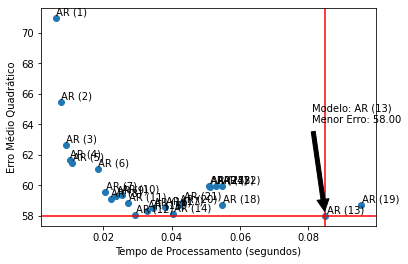

In [37]:
import numpy as np
import matplotlib.pyplot as plt

errors = ar['error_list']
proc_times = ar['proc_time_list']
n = [f"{ar['model']} ({order})" for order in ar['order_list']]

fig, ax = plt.subplots()
ax.scatter(proc_times, errors)

plt.xlabel("Tempo de Processamento (segundos)")
plt.ylabel("Erro Médio Quadrático")
    
best_error = min(errors)
#pos_x = min(z)
for e, t in zip(errors,proc_times):
    if e == best_error:
        proc_time = t
plt.axhline(y=best_error, color='r', linestyle='-')
plt.axvline(x=proc_time, color='r', linestyle='-')

for i, txt in enumerate(n):
    ax.annotate(txt, xy=(proc_times[i], errors[i]), xytext=(proc_times[i]*1.005, errors[i]*1.003))
    if errors[i] == best_error:
        ax.annotate(f"Modelo: {best_ar['model']} ({best_ar['best_order']})\nMenor Erro: {best_ar['best_error']:.2f}", 
                    xy=(proc_times[i], errors[i]), 
                    xytext=(proc_times[i]*0.955, errors[i]*1.105), 
                    arrowprops=dict(facecolor='black', shrink=0.05))

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATIO

25.207386564003997

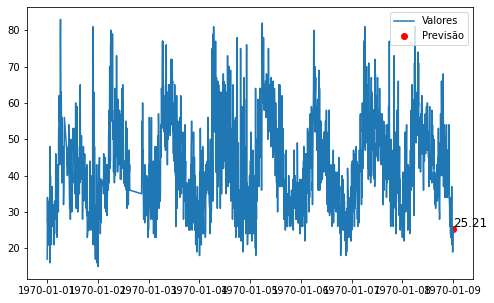

In [38]:
def predict(serie, order, plot=False):
    model = AR(serie).fit(order)
    next_period = serie.index[-1] + pd.Timedelta('5 minute')
    predict = model.predict(
        start=next_period, 
        end=next_period)
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(serie)
        plt.scatter(
            serie.index[-1], 
            predict[0], 
            color='red')
        plt.text(serie.index[-1], 
                 predict[0]*1.025 , 
                 f'{predict[0]:.2f}', 
                 fontsize=12)
        plt.legend(['Valores', 'Previsão'])
    return predict[0]
predict(dataframe('m_3330.csv').cpu, 13, plot=True)

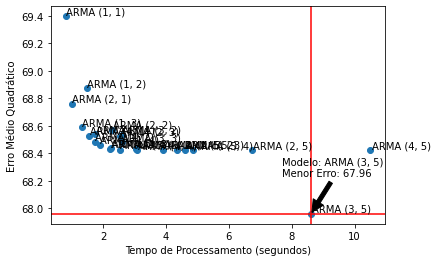

In [39]:
import numpy as np
import matplotlib.pyplot as plt

errors = arma['error_list']
proc_times = arma['proc_time_list']
models = [f"{arma['model']} {order}" for order in arma['order_list']]

fig, ax = plt.subplots()
ax.scatter(proc_times, errors)

plt.xlabel("Tempo de Processamento (segundos)")
plt.ylabel("Erro Médio Quadrático")
    
best_error = min(errors)
#pos_x = min(z)
for e, t in zip(errors,proc_times):
    if e == best_error:
        proc_time = t
plt.axhline(y=best_error, color='r', linestyle='-')
plt.axvline(x=proc_time, color='r', linestyle='-')

for i, model in enumerate(models):
    ax.annotate(model, xy=(proc_times[i], errors[i]), xytext=(proc_times[i]*1.005, errors[i]*1.0002))
    if errors[i] == best_error:
        ax.annotate(f"Modelo: {best_arma['model']} {best_arma['best_order']}\nMenor Erro: {best_arma['best_error']:.2f}", 
                    xy=(proc_times[i], errors[i]), 
                    xytext=(proc_times[i]*0.895, errors[i]*1.004), 
                    arrowprops=dict(facecolor='black', shrink=0.05))


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


25.10870836916871

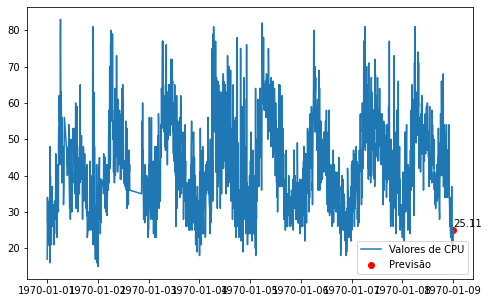

In [40]:
def predict(serie, order, plot=False):
    model = ARMA(serie, freq='5T', order=order).fit()
    forecast = model.forecast()[0][0]
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(serie)
        plt.scatter(serie.index[-1], 
                    forecast, color='red')
        plt.text(serie.index[-1], 
                 forecast*1.035, f'{forecast:.2f}')
        plt.legend(['Valores de CPU', 'Previsão'])
    return forecast
predict(dataframe('m_3330.csv').cpu, (3, 5), plot=True)

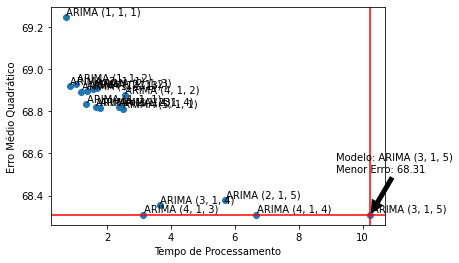

In [41]:
import numpy as np
import matplotlib.pyplot as plt

errors = arima['error_list']
proc_times = arima['proc_time_list']
models = [f"{arima['model']} {order}" for order in arima['order_list']]

fig, ax = plt.subplots()
ax.scatter(proc_times, errors)

plt.xlabel("Tempo de Processamento")
plt.ylabel("Erro Médio Quadrático")

    
best_error = min(errors)
#pos_x = min(z)
for e, t in zip(errors,proc_times):
    if e == best_error:
        proc_time = t
plt.axhline(y=best_error, color='r', linestyle='-')
plt.axvline(x=proc_time, color='r', linestyle='-')


for i, model in enumerate(models):
    ax.annotate(model, xy=(proc_times[i], errors[i]), xytext=(proc_times[i]*1.005, errors[i]*1.0002))
    if errors[i] == best_error:
        ax.annotate(f"Modelo: {best_arima['model']} {best_arima['best_order']}\nMenor Erro: {best_arima['best_error']:.2f}",
                    xy=(proc_times[i], errors[i]), 
                    xytext=(proc_times[i]*0.895, errors[i]*1.003), 
                    arrowprops=dict(facecolor='black', shrink=0.05))


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encounter

24.1365129261442

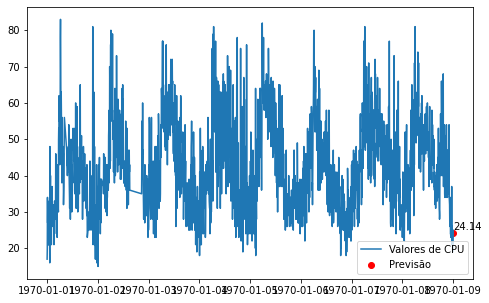

In [42]:
def predict(serie, order, plot=False):
    model = ARIMA(serie, freq='5T', order=order).fit()
    forecast = model.forecast()[0][0]
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(serie)
        plt.scatter(serie.index[-1], 
                    forecast, color='red')
        plt.text(serie.index[-1], 
                 forecast*1.035, f'{forecast:.2f}')
        plt.legend(['Valores de CPU', 'Previsão'])
    return forecast
predict(dataframe('m_3330.csv').cpu, (3, 1, 5), plot=True)

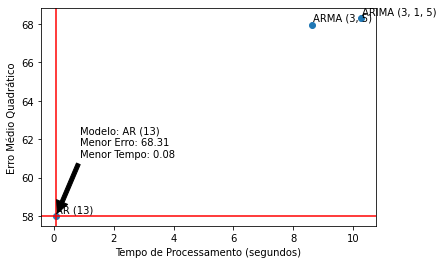

In [44]:
import numpy as np
import matplotlib.pyplot as plt

orders = [best_ar['best_order'], best_arma['best_order'], best_arima['best_order']]
errors = [best_ar['best_error'], best_arma['best_error'], best_arima['best_error']]
proc_times = [best_ar['best_time'], best_arma['best_time'], best_arima['best_time']]
models = [f"{best_ar['model']} ({best_ar['best_order']})", f"{best_arma['model']} {best_arma['best_order']}", f"{best_arima['model']} {best_arima['best_order']}"]

fig, ax = plt.subplots()
ax.scatter(proc_times, errors)

plt.xlabel("Tempo de Processamento (segundos)")
plt.ylabel("Erro Médio Quadrático")

    
best_time = min(proc_times)
#pos_x = min(z)
for m, o, e, t in zip(models,orders,errors,proc_times):
    if t == best_time:
        model = m
        order = o
        error = e
        proc_time = t
plt.axhline(y=error, color='r', linestyle='-')
plt.axvline(x=proc_time, color='r', linestyle='-')

for i, model in enumerate(models):
    ax.annotate(model, xy=(proc_times[i], errors[i]), xytext=(proc_times[i]*1.005, errors[i]*1.003))
    if proc_times[i] == best_time:
        ax.annotate(f"Modelo: {model}\nMenor Erro: {best_error:.2f}\nMenor Tempo: {best_time:.2f}", 
                    xy=(proc_times[i], errors[i]), 
                    xytext=(proc_times[i]*10.515, errors[i]*1.053), 
                    arrowprops=dict(facecolor='black', shrink=0.05))
